### TRAINING SEGMENTATION MODEL
Jupyter notebook for training of 2nd stage segmentation model
* [Importing modules](#imports)
* [Importing training data](#training-data-import)
* [Training parameters](#training-parameters)
* [Training init](#training-init)
* [Neptune parameters tracking](#Neptune-parameters-tracking)
* [Training](#training)
* [Eval](#Eval)

# Imports

In [ ]:
import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import os, sys, json, random
import cv2 as cv
from matplotlib import pyplot as plt
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from PARAMETERS import *


In [ ]:
print('Is CUDA available:',torch.cuda.is_available())
print('CUDA version:',torch.version.cuda)
print('Torch.version:',torch.__version__)
print('Detectron2 version:',detectron2.__version__)
print('Device:',torch.cuda.get_device_name(0))

In [ ]:
# Checking allocated memory
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0) 
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
print(f"{r} {a}")

# Training parameters

In [ ]:
network_config = r"COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
base_lr = 0.00025
solver_max_iter = 3000
eval_period = 100
batch_size_per_image = 8

# Training data import

In [ ]:
from detectron2.data.datasets import register_coco_instances
from PARAMETERS import PATH_TRAINING_DATA_SEGMENTATION
from tkinter_dialog_custom import askdirectory

while True:
    CURRENT_DATASET = askdirectory(title="Select dataset folder", initialdir=PATH_TRAINING_DATA_SEGMENTATION)
    if os.path.exists(CURRENT_DATASET): break


# Register a COCO Format Dataset
register_coco_instances(
    "TCM_train",{}, 
    os.path.join(CURRENT_DATASET,r"annotations/data_train.json"),
    os.path.join(CURRENT_DATASET,r"train"), 
)
register_coco_instances(
    "TCM_val",{},
    os.path.join(CURRENT_DATASET,r"annotations/data_val.json"),
    os.path.join(CURRENT_DATASET,r"val"),
)
register_coco_instances(
    "TCM_test",{},
    os.path.join(CURRENT_DATASET,r"annotations/data_test.json"),
    os.path.join(CURRENT_DATASET,r"test"), 
)

In [ ]:

# Visualize training data
my_dataset_train_metadata = MetadataCatalog.get("TCM_train")
my_dataset_test_metadata = MetadataCatalog.get("TCM_test")
my_dataset_val_metadata = MetadataCatalog.get("TCM_val")
dataset_dicts = DatasetCatalog.get("TCM_test")

images_array = []
for d in random.sample(dataset_dicts, 4):
    img = cv.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata = my_dataset_train_metadata, scale=0.8,instance_mode = ColorMode.IMAGE_BW)
    vis = visualizer.draw_dataset_dict(d)
    images_array.append(vis.get_image()[:, :, ::-1])

def plotImages(images_arr,nx,ny):
    fig, axes = plt.subplots(nx, ny, figsize=(80,nx*20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)  
        ax.axis('Off')
    fig.tight_layout()
    fig.show()
    
plotImages(images_array,1,4)

# Training init

Neptune init

In [ ]:
# Neptune setup
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import neptune.new as neptune

from PARAMETERS import NEPTUNE_SEGMENTATION_PROJECT_PATH

run = neptune.init(
    project=NEPTUNE_SEGMENTATION_PROJECT_PATH,
    api_token=os.environ.get('NEPTUNE_API_TOKEN'),
) 

Custom Hook

In [ ]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime
import logging
from detectron2.utils.events import get_event_storage

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    f"Loss on Validation  done {idx+1:d}/{total:d}. {seconds_per_img:.4f} s / img. ETA={str(eta)}",
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        run["training/batch/val_loss"].log(mean_loss)
        storage = get_event_storage()
        
        # AP
        segm_AP = "{:.5g}".format(storage.history("segm/AP").latest()) 
        run["training/batch/segm_AP"].log(float(segm_AP))
        segm_AP75 = "{:.5g}".format(storage.history("segm/AP75").latest()) 
        run["training/batch/segm_AP75"].log(float(segm_AP75))
        
        # Classes AP
        segm_AP_narost = "{:.5g}".format(storage.history("segm/AP-narost").latest()) 
        run["training/batch/segm_AP_narost"].log(float(segm_AP_narost))
        segm_AP_stepienie = "{:.5g}".format(storage.history("segm/AP-stepienie").latest()) 
        run["training/batch/segm_AP_stepienie"].log(float(segm_AP_stepienie))
        segm_AP_wykruszenie = "{:.5g}".format(storage.history("segm/AP-wykruszenie").latest()) 
        run["training/batch/segm_AP_wykruszenie"].log(float(segm_AP_wykruszenie))
        segm_AP_zatarcie = "{:.5g}".format(storage.history("segm/AP-zatarcie").latest()) 
        run["training/batch/segm_AP_zatarcie"].log(float(segm_AP_zatarcie))    
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
           
    def track_metrics(self):
        # Getting metrics from the detectron event storage 
        storage = get_event_storage()
        try:    lr = "{:.5g}".format(storage.history("lr").latest()) 
        except  KeyError: lr = "N/A"
        try:    total_loss = "{:.5g}".format(storage.history("total_loss").latest()) 
        except  KeyError: total_loss = "N/A"
        try:    loss_cls = "{:.5g}".format(storage.history("loss_cls").latest()) 
        except  KeyError: loss_cls = "N/A"
        try:    loss_box_reg = "{:.5g}".format(storage.history("loss_box_reg").latest()) 
        except  KeyError: loss_box_reg = "N/A"
        try:    loss_mask = "{:.5g}".format(storage.history("loss_mask").latest()) 
        except  KeyError: loss_mask = "N/A"
        try:    loss_rpn_cls = "{:.5g}".format(storage.history("loss_rpn_cls").latest()) 
        except  KeyError: loss_rpn_cls = "N/A"  
        try:    loss_rpn_loc = "{:.5g}".format(storage.history("loss_rpn_loc").latest()) 
        except  KeyError: loss_rpn_loc = "N/A"       

        # Saving those metrics to the neptune
        run["training/batch/lr"].log(float(lr))
        run["training/batch/total_loss"].log(float(total_loss))
        run["training/batch/loss_cls"].log(float(loss_cls))
        run["training/batch/loss_box_reg"].log(float(loss_box_reg))
        run["training/batch/loss_mask"].log(float(loss_mask))
        run["training/batch/loss_rpn_cls"].log(float(loss_rpn_cls))
        run["training/batch/loss_rpn_loc"].log(float(loss_rpn_loc))

             
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        # Perform loss evaluation every cfg.TEST.EVAL_PERIOD iterations
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)
        # Catch metrics every 20 iterations
        if self.trainer.iter % 20 == 0:
            self.track_metrics()

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

# Applying traning parameters

In [ ]:

from PARAMETERS import PATH_TRAINING_OUTPUT_DIR_SEGMENTATION

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(network_config))
cfg.DATASETS.TRAIN = ("TCM_train",)
cfg.DATASETS.TEST = ("TCM_val",)
cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(network_config)
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = base_lr
cfg.SOLVER.MAX_ITER = solver_max_iter
cfg.TEST.EVAL_PERIOD = eval_period
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = batch_size_per_image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
cfg.OUTPUT_DIR =  PATH_TRAINING_OUTPUT_DIR_SEGMENTATION
os.makedirs(cfg.OUTPUT_DIR, exist_ok = True)
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume = False)


# Neptune parameters tracking

In [ ]:
params = {
    "model": network_config.replace("\\\\","\\").replace("\\","/").split("/")[-1],
    "n_classes": cfg.MODEL.ROI_HEADS.NUM_CLASSES,
    "lr": cfg.SOLVER.BASE_LR,
    "max_iter": cfg.SOLVER.MAX_ITER,
    "eval_period": cfg.TEST.EVAL_PERIOD,
    "batch_size": cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE,
    "items_per_batch": cfg.SOLVER.IMS_PER_BATCH,
    "num_workers": cfg.DATALOADER.NUM_WORKERS,
    "device": torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu",
    "dataset": CURRENT_DATASET.replace("\\","/").split("/")[-1]
}
run["config/parameters"] = params

In [ ]:
dataset_size = {
    "train": len(DatasetCatalog.get("TCM_train")),
    "val": len(DatasetCatalog.get("TCM_val")),
    "test": len(DatasetCatalog.get("TCM_test")) 
}


run["config/dataset/dataset_size"] = dataset_size

# Training

In [13]:
trainer.train()

[06/20 15:03:16 d2.utils.events]:  eta: 1:46:31  iter: 39  total_loss: 3.548  loss_cls: 1.364  loss_box_reg: 0.7994  loss_mask: 0.6939  loss_rpn_cls: 0.3634  loss_rpn_loc: 0.1093  time: 1.3245  data_time: 0.0172  lr: 9.9902e-06  max_mem: 3816M
[06/20 15:03:43 d2.utils.events]:  eta: 1:47:53  iter: 59  total_loss: 3.32  loss_cls: 1.152  loss_box_reg: 0.7663  loss_mask: 0.6922  loss_rpn_cls: 0.3357  loss_rpn_loc: 0.2301  time: 1.3332  data_time: 0.0319  lr: 1.4985e-05  max_mem: 3816M
[06/20 15:04:10 d2.utils.events]:  eta: 1:48:14  iter: 79  total_loss: 2.904  loss_cls: 0.9922  loss_box_reg: 0.8595  loss_mask: 0.6907  loss_rpn_cls: 0.1244  loss_rpn_loc: 0.1511  time: 1.3317  data_time: 0.0101  lr: 1.998e-05  max_mem: 3816M
WARNING [06/20 15:04:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/20 15:04:37 d2.data.datasets.coco]: Loaded 102 images in COCO format from Z:/TCM/trening/DATASETY/segmentacja/DAT_3_v2\annotati

# Eval

Short summary of the main model metrics

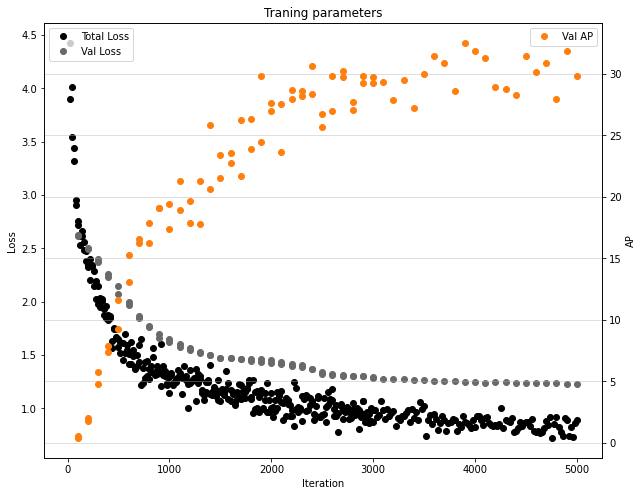

In [14]:
import json
import matplotlib.pyplot as plt
from PARAMETERS import PATH_TRAINING_OUTPUT_DIR_SEGMENTATION

experiment_folder = PATH_TRAINING_OUTPUT_DIR_SEGMENTATION

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
try:
    ax1.plot(
        [x['iteration'] for x in experiment_metrics if 'total_loss' in x],
        [x['total_loss'] for x in experiment_metrics if 'total_loss' in x], color="black", label="Total Loss", linestyle="none", marker="o")
except ValueError: pass
try:
    ax1.plot(
        [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
        [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x], color="dimgray", label="Val Loss", linestyle="none", marker="o")
except ValueError: pass
ax1.tick_params(axis='y')
plt.legend(loc='upper left')

ax2 = ax1.twinx()

color = 'tab:orange'
ax2.set_ylabel('AP')
try:
    ax2.plot(
        [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
        [x['bbox/AP'] for x in experiment_metrics if 'bbox/AP' in x], color=color, label="Val AP", linestyle="none", marker="o")
except ValueError: pass
ax2.tick_params(axis='y')

plt.legend(loc='upper right')
plt.grid(alpha=0.5)
fig.set_size_inches(10,8)
plt.title("Traning parameters")
plt.savefig(os.path.join(experiment_folder,'model_metrics.png'))
plt.show()

Eval functions

In [15]:
from tidecv import TIDE, datasets
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import json
import statistics
import glob

# for evaluation without training
from PARAMETERS import *
from tkinter_dialog_custom import askdirectory
try:
    CURRENT_DATASET
except NameError:
    print("No dataset selected! Please select a dataset:")
    while True:
        CURRENT_DATASET = askdirectory(title="Select dataset folder", initialdir=PATH_TRAINING_DATA_SEGMENTATION)
        if os.path.exists(CURRENT_DATASET): break


path_to_tide = os.path.join(PATH_TRAINING_OUTPUT_DIR_SEGMENTATION,r'tide')
path_to_coco_dataset = os.path.join(CURRENT_DATASET, r'annotations\data_test.json')
path_to_coco_eval = os.path.join(PATH_TRAINING_OUTPUT_DIR_SEGMENTATION,r'COCO_eval')
path_to_coco_results = os.path.join(path_to_coco_eval,r'coco_instances_results.json')

# Calculate TIDE metrics based on COCOEvaluator
def TIDE_evaluation():
    tide = TIDE(pos_threshold=0.75)
    gt = datasets.COCO(path_to_coco_dataset)
    tide.evaluate(gt, datasets.COCOResult(path_to_coco_results),mode=TIDE.BOX) 
    tide.plot(f"{path_to_tide}\\tresh_{str(THRESHOLD)}")       # Show a summary figure. Specify a folder and it'll output a png to that folder.
    tide.evaluate(gt, datasets.COCOResult(path_to_coco_results),mode=TIDE.MASK) 
    tide.summarize()  # Summarize the results as tables in the console
    tide.plot(f"{path_to_tide}\\tresh_{str(THRESHOLD)}")       # Show a summary figure. Specify a folder and it'll output a png to that folder.
    
    # Passing tide eval results to the Neptune 
    tide_eval = tide.get_main_errors()['coco_instances_results']
    run["eval/tide_mask/tresh_" + str(THRESHOLD)] = tide_eval

# Inference from test dataset, provide basic COCO AP metrics
def COCO_evaluation():
    #Call the COCO Evaluator function and pass the Validation Dataset
    evaluator = COCOEvaluator("TCM_test", cfg, False, output_dir = path_to_coco_eval)
    val_loader = build_detection_test_loader(cfg, "TCM_test")

    # Use the created predicted model in the previous step
    results = inference_on_dataset(predictor.model, val_loader, evaluator)
    
    # Passing coco eval results to the Neptune 
    run["eval/coco_segm/tresh_" + str(THRESHOLD)] = results['segm']
    run["eval/coco_bbox/tresh_" + str(THRESHOLD)] = results['bbox']

def custom_eval(segmentation_predictor,path_current_dataset):
    pth = os.path.join(path_current_dataset, r'test').replace('\\\\','\\').replace('\\','/')

    metrics = dict()
    results = dict()
    
    for value in list(DICTIONARY_FAILURES.values())+["Global"]:
            results[value] = {
                "Recall":0,
                "Precision":0,
                "Accuracy":0,
                "Specificity":0,
                "F1":0,
            }
    
    for value in list(DICTIONARY_FAILURES.values())+["Global"]:
            metrics[value] = {
                "TP":[],
                "TN":[],
                "FP":[],
                "FN":[],
            }
    

    for label in glob.glob(f'{pth}/*json'): # iterate through eval dataset
        base_name = (label.replace('\\\\','\\').replace('\\','/').split('/')[-1]).split('.')[0]
        file = open(label, 'r')
        json_label = json.load(file )
        im = cv.imread(os.path.join(pth,f"{base_name}.png"))
        pred_classes, image_metrics = calculate_metrics_for_image(im, json_label, segmentation_predictor)
        
        for class_name in list(image_metrics.keys()):
            for metric_name, metric_val in zip(list(image_metrics[class_name].keys()),list(image_metrics[class_name].values())):
                metrics[class_name][metric_name].append(metric_val)
                metrics["Global"][metric_name].append(metric_val)

    # calculate metrics for entire run
    for class_name in list(results.keys()):
        TP = sum(metrics[class_name]["TP"])
        TN = sum(metrics[class_name]["TN"])
        FP = sum(metrics[class_name]["FP"])
        FN = sum(metrics[class_name]["FN"])
        accuracy = (TP+TN)/(TP+TN+FP+FN) # Accuracy is a measure of how many of the predictions were correct
        precision = TP/(TP+FP) if (TP+FP) != 0 else -1 # Precision is a measure of how many of the positive predictions made are correct (true positives)
        recall = TP/(TP+FN) if (TP+FN) != 0 else -1 # Recall is a measure of how many of the positive cases the classifier correctly predicted
        specificity = TN / (TN + FP) # Specificity is a measure of how many negative predictions made are correct (true negatives). 
        F1_score = (2*precision*recall) / (precision+recall) if (precision != -1 and recall != -1) else -1
        results[class_name]["Recall"] = recall
        results[class_name]["Accuracy"] = accuracy
        results[class_name]["Precision"] = precision
        results[class_name]["Specificity"] = specificity
        results[class_name]["F1"] = F1_score

   
    for class_name in list(results.keys()):
        print(
            f"""
            For class {class_name}
                F1 = {results[class_name]["F1"]}
            """
        )
    return results

def calculate_metrics_for_image(im, json_label, segmentation_predictor):
        #cv.imshow("test",im)
        im_h, im_w, _ = im.shape

        label_outputs = dict()
        for value in DICTIONARY_FAILURES.values():
            label_outputs[str(value)] = np.zeros_like(im)
        
        # Iterate over labels from .json file, merge it into 4 categories, draw it as bitmaps
        for shape in json_label["shapes"]:
            point_list = np.array(shape['points'])
            if len(point_list) > 2:
                pts = point_list.reshape((-1, 1, 2))  
                for class_name in DICTIONARY_FAILURES.values(): # Iterate over all instances classes
                    if(shape["label"]==class_name):
                        label_outputs[class_name] = cv.fillPoly(label_outputs[class_name], np.int32([pts]), (255,255,255))
                        
        # Segmentation model inference
        predictions = segmentation_predictor(im) # Make prediction 
        pred_masks = predictions["instances"].to("cpu").pred_masks.numpy()
        pred_classes = predictions["instances"].to("cpu").pred_classes.numpy()
        num_instances = pred_masks.shape[0] 
        pred_masks = np.moveaxis(pred_masks, 0, -1)
        
        # Contains merged bitmaps for particular failures classes
        inference_outputs = dict()
        for value in DICTIONARY_FAILURES.values():
            inference_outputs[str(value)] = np.zeros_like(im)

        # Contains temporary data used during merging
        pred_masks_instance = dict()
        for value in DICTIONARY_FAILURES.values():
            pred_masks_instance[str(value)] = []

        # Iterate over predicted defects, search for duplicated instances of the same class and merge them into single bitmap.
        for i in range(num_instances): 
            for class_id in DICTIONARY_FAILURES: # Iterate over all instances classes
                if(pred_classes[i] == class_id): 
                    failure_class = DICTIONARY_FAILURES[class_id] # Get name of the current class
                    pred_masks_instance[failure_class].append(pred_masks[:, :, i:(i+1)]) 
                    inference_outputs[failure_class] = np.where(pred_masks_instance[failure_class][-1] == True, 255, inference_outputs[failure_class])
    
        image_metrics = dict()

        for value in DICTIONARY_FAILURES.values():
            image_metrics[str(value)] = {
                "TP":0.0,
                "TN":0.0,
                "FP":0.0,
                "FN":0.0,
            }

        for class_name in DICTIONARY_FAILURES.values():
            # iterate through all potential failures
        
            pred = cv.cvtColor(inference_outputs[class_name], cv.COLOR_BGR2GRAY)
            label = cv.cvtColor(label_outputs[class_name], cv.COLOR_BGR2GRAY)
            bitwiseOr = cv.bitwise_or(pred, label)
            bitwiseAnd = cv.bitwise_and(pred, label) 
            #bitwiseXor = cv.bitwise_xor(pred, label)

            TP = bitwiseAnd  # TP - a sample is predicted to be positive and its label is actually positive
            TN = cv.bitwise_not(bitwiseOr) # TN - a sample is predicted to be negative and its label is actually negative
            FP = cv.bitwise_xor(TP,pred) # FP - a sample is predicted to be positive and its label is actually negative
            FN = cv.bitwise_and(cv.bitwise_not(pred),cv.bitwise_xor(label,TP)) # FN - a sample is predicted to be negative and its label is actually positive

            im_size = im_h*im_w

            TP = cv.countNonZero(TP) / im_size # normalize to image size
            TN = cv.countNonZero(TN) / im_size
            FP = cv.countNonZero(FP) / im_size
            FN = cv.countNonZero(FN) / im_size

            image_metrics[class_name]["TP"] = cv.countNonZero(TP)
            image_metrics[class_name]["TN"] = cv.countNonZero(TN)
            image_metrics[class_name]["FP"] = cv.countNonZero(FP)
            image_metrics[class_name]["FN"] = cv.countNonZero(FN)

        return pred_classes, image_metrics


In [16]:
F1_scores = []
F1_scores_stepienie, F1_scores_wykruszenie, F1_scores_zatarcie, F1_scores_narost = [],[],[],[]
Accuracy, Specificity = [],[]
thresholds = []
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("TCM_test", )

output_metrics = dict()
for value in list(DICTIONARY_FAILURES.values())+["Global"]:
    output_metrics[value] = {
            "Recall":[],
            "Precision":[],
            "Accuracy":[],
            "Specificity":[],
            "F1":[],
        }


for THRESHOLD in np.arange(0.3, 1.0, 0.05): #Iterate over various thresholds to find best results
    THRESHOLD = float(round(THRESHOLD,2))
    thresholds.append(THRESHOLD*100)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = THRESHOLD
    predictor = DefaultPredictor(cfg)
    test_metadata = MetadataCatalog.get("TCM_test")
    #COCO_evaluation() # include coco
    #TIDE_evaluation() # include tide metrics
    print("Threshold",THRESHOLD)
    eval_results = custom_eval(predictor, CURRENT_DATASET)
    for class_name in list(eval_results.keys()):
        for metric in list(eval_results[class_name].keys()):
            output_metrics[class_name][metric].append(eval_results[class_name][metric])

[06/20 18:08:24 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

c:\Users\KacperMarciniak\anaconda3\envs\env_main\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
c:\Users\KacperMarciniak\anaconda3\envs\env_main\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


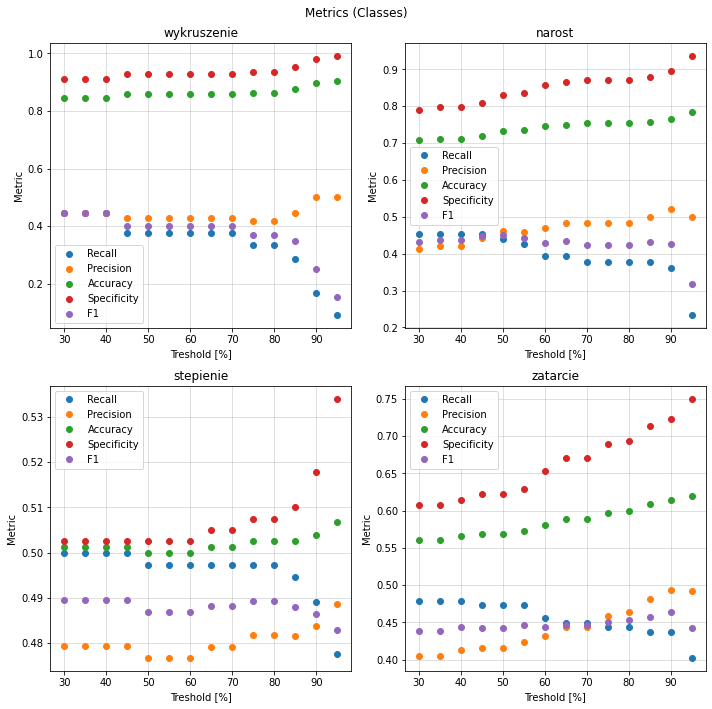

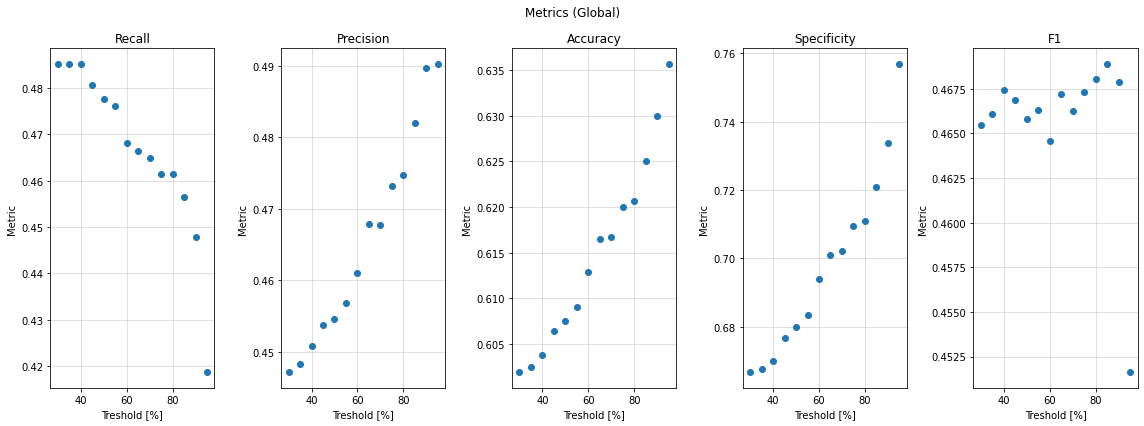

In [17]:
experiment_folder = PATH_TRAINING_OUTPUT_DIR_SEGMENTATION

fig_class_scores, axes = plt.subplots(nrows=2,ncols=2)
axes = axes.flatten()

fig_class_scores.suptitle("Metrics (Classes)")
class_titles = list(DICTIONARY_FAILURES.values())
for i,ax in enumerate(axes):
    current_class_data = output_metrics[class_titles[i]]
    ax.set_xlabel('Threshold [%]')
    ax.set_ylabel('Metric')
    ax.set_title(class_titles[i])
    ax.grid(alpha=0.5)
    for key,data in zip(list(current_class_data.keys()),list(current_class_data.values())):
        ax.plot(thresholds,data,marker="o",linestyle="none",label=key)
    ax.legend()
fig_class_scores.set_size_inches(10,10)
fig_class_scores.tight_layout()
fig_class_scores.savefig(os.path.join(experiment_folder,'F1_class_scores.png'))
fig_class_scores.show()

fig_global_metrics, axes = plt.subplots(ncols=5)
axes = axes.flatten()

fig_global_metrics.suptitle("Metrics (Global)")
for i,ax in enumerate(axes):
    metric_key,metric_val = list(output_metrics["Global"].keys())[i], list(output_metrics["Global"].values())[i]
    ax.plot(thresholds,metric_val,marker="o",linestyle="none",label=metric_key)
    ax.set_xlabel('Threshold [%]')
    ax.set_ylabel('Metric')
    ax.grid(alpha=0.5)
    ax.set_title(metric_key)
fig_global_metrics.set_size_inches(16,6)
fig_global_metrics.tight_layout()
fig_global_metrics.savefig(os.path.join(experiment_folder,'Global_metrics.png'))
fig_global_metrics.show()

In [18]:
"""params = {
    "F1": max(F1_scores),
    "tresh": thresholds[F1_scores.index(max(F1_scores))],
    "F1_stepienie": F1_scores_stepienie[F1_scores.index(max(F1_scores))],
    "F1_narost": F1_scores_narost[F1_scores.index(max(F1_scores))],
    "F1_zatarcie": F1_scores_zatarcie[F1_scores.index(max(F1_scores))],
    "F1_wykruszenie": F1_scores_wykruszenie[F1_scores.index(max(F1_scores))],
    "accuracy": Accuracy[F1_scores.index(max(F1_scores))],
    "specificity": Specificity[F1_scores.index(max(F1_scores))],
}"""
params=0
try:
    run["eval/F1_score_best"] = params
    run["eval/F1_scores_classes_img"].upload(os.path.join(experiment_folder,'F1_class_scores.png'))
    run["eval/Global_metrics_img"].upload(os.path.join(experiment_folder,'Global_metrics.png'))

    from neptune.new.types import File
    run["eval/F1_scores_classes"] = File.as_html(fig_class_scores)
    run["eval/Global_metrics"] = File.as_html(fig_global_metrics)
except NameError:
    print("Neptune is not initialized")

print("Chosen parameters")
for key in params.keys():
    print(f"{key} -> {params[key]}")

c:\Users\KacperMarciniak\anaconda3\envs\env_main\lib\site-packages\plotly\matplotlylib\renderer.py:612: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Chosen parameters


AttributeError: 'int' object has no attribute 'keys'

Unexpected error occurred in Neptune background thread: Killing Neptune asynchronous thread. All data is safe on disk and can be later synced manually using `neptune sync` command.


Exception in thread NeptuneAsyncOpProcessor:
Traceback (most recent call last):
  File "c:\Users\KacperMarciniak\anaconda3\envs\env_main\lib\site-packages\urllib3\connectionpool.py", line 710, in urlopen
    chunked=chunked,
  File "c:\Users\KacperMarciniak\anaconda3\envs\env_main\lib\site-packages\urllib3\connectionpool.py", line 449, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "c:\Users\KacperMarciniak\anaconda3\envs\env_main\lib\site-packages\urllib3\connectionpool.py", line 444, in _make_request
    httplib_response = conn.getresponse()
  File "c:\Users\KacperMarciniak\anaconda3\envs\env_main\lib\http\client.py", line 1373, in getresponse
    response.begin()
  File "c:\Users\KacperMarciniak\anaconda3\envs\env_main\lib\http\client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "c:\Users\KacperMarciniak\anaconda3\envs\env_main\lib\http\client.py", line 280, in _read_status
    line = str(self.fp.readl

Neptune stop

In [ ]:

# Neptune stop
run.stop()


# Displaying

In [ ]:
"""from PIL import Image 

path_displaying = os.path.join(PATH_TRAINING_OUTPUT_DIR_SEGMENTATION,"displaying")
path_test_images = os.path.join(CURRENT_DATASET,r'test')
os.makedirs(path_displaying, exist_ok = True)

def decode_segmentation(imageName):
    im = cv.imread(os.path.join(path_test_images,imageName))
    outputs = predictor(im)
    base_name = imageName.split('.')[0]
    pred_masks = outputs["instances"].to("cpu").pred_masks.numpy()
    num_instances = pred_masks.shape[0] 
    pred_masks = np.moveaxis(pred_masks, 0, -1)
    pred_masks_instance = []
    output = np.zeros_like(im)

    scores = outputs["instances"].to("cpu").scores.numpy()
    pred_classes = outputs["instances"].to("cpu").pred_classes.numpy()
    line = f"{str(num_instances)}, {str(pred_classes)}, {str(scores)}"
    out_txt_name = (path_displaying,f'{base_name}.txt')
    '''
    with open(out_txt_name, 'w') as f:
        f.write(line)
        f.close()
    '''
    for i in range(num_instances):
        out_png_name = path_displaying, f'{base_name}-{i}.png'     
        pred_masks_instance.append(pred_masks[:, :, i:(i+1)])
        output = np.where(pred_masks_instance[0] == True, 255, output)
        im = Image.fromarray(output)
        output = np.zeros_like(im)
        pred_masks_instance = []
        #im.save(out_png_name)
"""

Inference on random picked images

In [ ]:
"""from detectron2.utils.visualizer import ColorMode
import glob
pth = r'D:\Konrad\TCM_scan\Skany_nowe_pwr\pwr_a_1_20210930\otsu_tooth2'
files = os.listdir(pth)

for imageName in files:
  decode_segmentation(imageName)"""

In [ ]:
"""from detectron2.utils.visualizer import ColorMode
import glob

images_array=[]
for imageName in glob.glob(f'{CURRENT_DATASET}\\test\\*png'):
  #print(str(imageName))
  im = cv.imread(imageName)
  outputs = predictor(im)

  v = Visualizer(im[:, :, ::-1], metadata=test_metadata,  scale=0.3,instance_mode=ColorMode.SEGMENTATION)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  images_array.append(out.get_image()[:, :, ::-1])
"""


Sample images plotting

In [ ]:
"""plotImages(images_array,4,3)"""

In [ ]:

'''path = r'D:\Konrad\TCM_scan\dash_skany\pwr_a_1_20210930_100324\otsu_tooth'

files = os.listdir(path)
containers = []
containers.append(('000',0,0))
row_max_x = 0
row_max_y = 0
i = 0
prev_name = '000'

for image_name in files:   
    base_name = image_name[:image_name.rfind('.')]
    split_name = base_name.split('_')
    row = split_name[1]
    im = cv.imread(path + '\\' + image_name)

    im = cv.cvtColor(im,cv.COLOR_BGR2GRAY)
    x,y = im.shape

    if (x > row_max_x): 
        row_max_x = x
        containers[i] = (row, row_max_x, row_max_y)
    if (y > row_max_y): 
        row_max_y = y
        containers[i] = (row, row_max_x, row_max_y)  
    if prev_name != row:
        print(containers[i])
        prev_name = row
        i += 1
        row_max_x = 0
        row_max_y = 0
        containers.append((row, 0, 0))
        
f.close()'''

